# Non-parametric regression 

We consider a regression model $Y=h(X)+E$ where $(X,Y)$ are the observations, $E$ is a gaussian noise and $h$ is the function we want to learn. We assume that $h$ belongs to the Hilbert space
$$ H = \{ f, f(x)= \int_0^x f'(s) ds \text{ with } f' \in L^2(0,1) \},$$
and that the support of the distribution of $X$ is included in $[0,1]$. 

We set $L(h)$ as the squared loss associated to the model (i.e $L(h) = \mathbb{E}(Y-h(X))^2$ ).

We can thus compute the Fréchet Gradient of $L$ with respect to $h$ as: $$\nabla L (h) (.) = \mathbb{E}\Biggl[ 2(Y-h(X)) \min(.,X) \Biggr] \ .$$

Theoretically, we have now all the tools to perform a simple gradient descent to learn $h$. If we denote by $(X_i,Y_i)_{i=1,..,n}$ our training sample, then the gradient descent update takes the form: 
$$ h^{t+1}(.) = h^t(.) - 2 \alpha \frac{1}{n} \sum_{i}(Y_i-h^t(X_i)) \min(.,X_i) \ ,$$ 
where $\alpha$ is the stepsize. 

The question now is : How do we compute it? We can't simply discretize the interval $[0,1]$ and learn the function in the points of the discretization, because doing so, we may not be able to compute the value $h(X)$ unless the value of $X$ falls into the discretization.

We offer here a true computation of the gradient descent above. That is, after T iterations, the function we plot is exactly $h^T$. The idea is to first compute the table $\{h^{t}(X_i)\}_{i \in [1,n], t \in [1,T]}$. Then, by a telescoping series argument, we have
$$ h^T(.) = h^0(.) - 2 \alpha \sum_{t=1,..,T} \frac{1}{n} \sum_{i} (Y_i - h^t(X_i)) \min(.,X_i) \ .$$

## A gradient-free approach

We used here the squared loss which gradient can be easily computed. However, for general losses, one can imagine a gradient that is not explicitly known or too coslty to be computed. In this case, referring to Malliavin Calculus, we know that for all $f,g \in H$
$$ \mathbb{E} \langle \nabla L (g), f \rangle = \mathbb{E} L(g) \int_0^1 f'(s) dB_s .$$

One can compute using this formula an unbiased estimate of the gradient using only the loss itself: 
$$ \hat{\nabla L} (h) (.) = \frac{1}{\gamma} L(h(X)+ \gamma B_X) B(.) \ ,$$
where $\gamma$ is a smoothing parameter.

Therefore, we can now perform the gradient-free SGD:
$$h^{t+1}(.) = h^t(.) -  \frac{\alpha}{\gamma} \frac{1}{n} \sum_{i} L(h^t(X_i)+ \gamma B^t_{X_i}) B^t(.) \ ,$$
which can be implemented exactly using the same argument as before.

## Changing the space H : new gradients

The Fréchet gradient depends on the space $H$. Therefore, it is important to have an expression of the gradient for different spaces $H$. We propose a method for computing the gradient for different Hilbert spaces strictly embedded in $H$.

Consider $H_2 = \{f \in H^2(0,1), f(0)=0, f^{'}(0)=0 \}$, where $H^2$ is the Sobolev space with integer $2$. The scalar product in $H_2$ is $$\langle f,g \rangle = \int_0^1 f' g' + \int_0^1 f'' g'' .$$
Therefore, to compute the Fréchet gradient of the linear form $h \mapsto h(t)$ for some fixed $t$, one needs to find $g$ in $H_2$ such that $$\int_0^1 g^{(4)}-g'' + [f' g"]_0^1 + [fg']_0^1 -[f g^{(3)}]_0^1 = g(t).$$
In a distributional sense, it is sufficient to find $g$ in $H_2$ such that
$$ -g^{(4)}+g'' = \delta_t ,$$ and $g''(1)=0, \ g^{(3)}(1)=g'(1)$. Solving the ODE this yields
$$ g''(x) = sinh(x-t) \mathbf{1}_{[0,t)}(x).$$

In general, one may consider the space $H_k = \{f \in H^k(0,1), f(0)=0,..,f^{k-1}(0)=0 \}$, and follow a similar analysis.

### Remark

The gradient-free formula given by Malliavin Calculus depends on the space $H$. 
(The adjoint operator changes)

# TODO
* clean and rerun for the three 1D payoff functions 
* reproduce for higher dimensions
* run a real-life example in higher dimension 
* run gradient-free examples with spectral risks

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from math import *
from sklearn import neighbors
import scipy
from scipy import stats, interpolate
from scipy.linalg import sqrtm
from scipy.misc import derivative
import numpy as np
from functools import partial


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

A Brownian Motion function 

In [2]:
def brownian(n_brownians):
    """
    Returns several trajectories of a brownian motion as functions which can be evaluated on any point
    """
    Y = np.linspace(0, 1, 1000)
    
    n = len(Y) 
    sample_values = np.zeros((n, n_brownians))
    step = 1 / n
    
    for i in range(n - 1):
        sample_values[i + 1] = sample_values[i] + sqrt(step) * np.random.randn(n_brownians)
        
    f = interpolate.interp1d(Y[np.newaxis:],sample_values,kind='linear',axis=0)
    return f

We define here the function we want to learn, which we call payoff

In [3]:
def payoff1D(t, name):
    if name == "sinus":
        return np.sin(2 * pi * t)
    elif name == "growingsinus":
        return np.square(0.1*t)*np.sin(1/(0.1*t + 1e-10)) 
    elif name == "sharpsinus":
        n_segments = 6
        breakpts = [i/n_segments for i in range(n_segments + 1)]
        max_abs_val = 1
        res = []
        def sharpsinus(x):
            if x == 0.:
                return 0.
            else:
                for i in range(n_segments):
                    if (x > breakpts[i]) and (x <= breakpts[i + 1]):
                        sign_d = 2 * (i % 2 == 0) - 1
                        a = n_segments
                        return sign_d * ((a * x)  - (i + int(i%2)) * a * 1/n_segments)
        if type(t) == np.float64:
            return sharpsinus(t)
        else:
            for x in t:
                res.append(sharpsinus(x)) 
            return res
    else:
        raise ValueError("{} is not a recognized payoff type".format(name))

In [4]:
def generate_data(n_train, n_test, noise_var=10, name_model="sinus", show=False):
    X = np.random.uniform(0, 1, n_train + n_test)
    
    X_train = X[:n_train]
    X_test = X[n_train:]
    
    # the independant noise
    E = np.random.normal(0, noise_var, n_train)
    Y_train = payoff1D(X_train, name_model) + E
    
    if show:
        plt.figure()
        plt.scatter(X_train, Y_train, s=5)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Training data")
        plt.show()
    return X_train, Y_train, X_test

In [5]:
# Set parameters for the experiment
n_train = 50
noise_variance = 0.2
model_name = "sinus"
n_test = 500

# params for H1 and H2 gradient descents
step1 = 0.1
step2 = 1
n_iter = 5000

# params for gradient-free descent
n_iter_gfree = 10000
gamma = 1
step_gfree = 0.01
n_brownians = 100

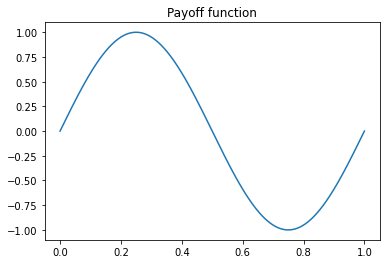

In [6]:
t = np.linspace(0,1,1000)
plt.plot(t, payoff1D(t, model_name))
plt.title("Payoff function")
plt.show()

Here's the noisy training data for our regression model

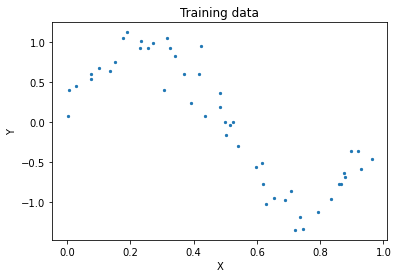

In [7]:
X_train, Y_train, X_test = generate_data(n_train, n_test, noise_var=noise_variance, name_model=model_name, show=True)
y_test = payoff1D(X_test, model_name)

In [8]:
def f0(t):
    # the identity function is our initialization
    return t.copy()

In [7]:
def h2_phi(t,x):
    term1 = - np.sinh(np.minimum(x,t) - t)
    term2 = - np.sinh(t) + np.cosh(t) * np.minimum(x,t)
    term3 =  - np.sinh(t) * (np.cosh(x) - 1) + np.sinh(t) * np.sinh(x) / np.sinh(1)
    return  term1 + term2 + term3

In [10]:
def h3_phi(x,t):
    """
    Expression not complete
    """
    return np.exp(x-t)/3 - (np.exp(-(x-t)/2)/3)*(np.cos(sqrt(3)*(x-t)/2) + sqrt(3)*np.sin(sqrt(3)*(x-t)/2))

In [11]:
def gradient_free_descent(X_train, Y_train, f0, gamma, n_iter=1000, step=0.05):
    n = len(X_train)
    F = np.zeros((n_iter,n))
    F[0, :] = f0(X_train)
    
    # Why n steps for n points?
    for i in tqdm(range(1, n_iter)):
        brownian_motions = B[i]
        bs = np.array([brownian_motions(x) for x in X_train])
        for j in range(n): 
            F[i,j] = F[i-1,j] -\
            (step/gamma) * np.mean(((F[i-1, :][:,np.newaxis] + gamma*bs - Y_train[:,np.newaxis])**2) * 
                                   brownian_motions(X_train[j]))
    return F

def gradient_free_f(xs, F_train, f0, X_train, Y_train, gamma, step=0.05, scalar=False, verbose=True):
    """
    Applying the learnt function to points outside the training sample
    """
    if not isinstance(xs, np.ndarray):
        xs = np.array([xs])
    n_iter = F_train.shape[0]
    n_test = len(xs)
    res = f0(xs)
    
    if verbose:
        rng = tqdm(range(n_iter - 1))
    else:
        rng = range(n_iter - 1)
        
    for j in rng: 
        brownian_motions = B[j]
        bs = np.array([brownian_motions(x_tr) for x_tr in X_train])
        loss_term = np.square(F_train[j,:][:,np.newaxis] + gamma*bs - Y_train[:,np.newaxis])[np.newaxis, :, :]
        res += -(step/gamma) * np.mean(loss_term * brownian_motions(xs)[:, np.newaxis, :], axis=(1, 2))
    if scalar:
        return res[0]
    return res

In [12]:
def gradient_descent(X_train, Y_train, f0, sobolev_idx, n_iter=1000, step=0.05):
    """
    Learning the function in the training sample points
    """
    n = len(X_train)
    F = np.zeros((n_iter,n))
    F[0, :] = f0(X_train)
    if sobolev_idx == 1:
        phi = np.minimum
    elif sobolev_idx == 2:
        phi = h2_phi
    
    # Why n steps for n points?
    for i in tqdm(range(1, n_iter)):
        F[i, :] = F[i-1, :] - 2 * step * np.mean((F[i-1,:] - Y_train) * phi(X_train[np.newaxis, :], 
                                                                            X_train[:, np.newaxis]), axis=1)
    return F

def f(xs, F_train, f0, X_train, Y_train, sobolev_idx, step=0.05, scalar=False, verbose=True):
    """
    Applying the learnt function to points outside the training sample
    """
    if not isinstance(xs, np.ndarray):
        xs = np.array([xs])
    if sobolev_idx == 1:
        phi = np.minimum
    elif sobolev_idx == 2:
        phi = h2_phi
    n_iter = F_train.shape[0]
    
    if verbose:
        rng = tqdm(range(n_iter - 1))
    else:
        rng = range(n_iter - 1)
        
    grads = np.array([np.mean(2 * step * (F_train[j, :] - Y_train) * phi(X_train[np.newaxis, :], xs[:, np.newaxis]), 
                              axis=1)
                      for j in rng])
    res = f0(xs) - np.sum(grads, axis=0)
    if scalar:
        return res[0]
    else:
        return res

In [13]:
F_train_h1 = gradient_descent(X_train, Y_train, f0, 1, n_iter, step1)
y_pred_test_h1 = f(X_test, F_train_h1, f0, X_train, Y_train, 1, step1)

100%|████████████████████████████████████| 4999/4999 [00:00<00:00, 18624.92it/s]


In [14]:
F_train_h2 = gradient_descent(X_train, Y_train, f0, 2, n_iter, step2)
y_pred_test_h2 = f(X_test, F_train_h2, f0, X_train, Y_train, 2, step2)

100%|█████████████████████████████████████| 4999/4999 [00:01<00:00, 3926.20it/s]


In [15]:
B = []
for i in tqdm(range(n_iter_gfree)):
    B.append(brownian(n_brownians))
    
F_train_gfree = gradient_free_descent(X_train, Y_train, f0, gamma, n_iter_gfree, step_gfree)
y_pred_test_gfree = gradient_free_f(X_test, F_train_gfree, f0, X_train, Y_train, gamma, step_gfree)

100%|██████████████████████████████████████| 9999/9999 [00:31<00:00, 320.53it/s]


Run baselines on the same data for comparison

In [16]:
knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights="distance")
knn_pred_y_test = knn.fit(X_train.reshape((-1, 1)), Y_train).predict(X_test.reshape((-1, 1)))

gpr = GaussianProcessRegressor().fit(X_train.reshape((-1, 1)), Y_train)
gpr_pred_y_test = gpr.predict(X_test.reshape((-1, 1)))

krr = KernelRidge(alpha=.0001, kernel=RBF()).fit(X_train.reshape((-1, 1)), Y_train)
krr_pred_y_test = krr.predict(X_test.reshape((-1, 1)))

Compare the results of both regressions to the ground truth

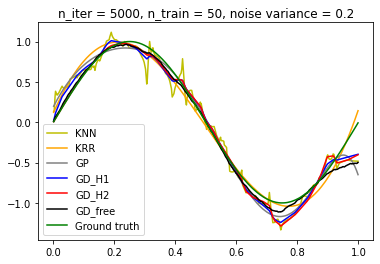

In [17]:
test_order = np.argsort(X_test)
plt.title("n_iter = {}, n_train = {}, noise variance = {}".format(n_iter,n_train, noise_variance))

sorted_X_test = np.sort(X_test)
plt.plot(sorted_X_test, knn_pred_y_test[test_order], label='KNN', color='y')
plt.plot(sorted_X_test, krr_pred_y_test[test_order], label='KRR', color='orange')
plt.plot(sorted_X_test, gpr_pred_y_test[test_order], label='GP', color='grey')
plt.plot(sorted_X_test, y_pred_test_h1[test_order], label='GD_H1', color='b')
plt.plot(sorted_X_test, y_pred_test_h2[test_order], label='GD_H2', color='r')
plt.plot(sorted_X_test, y_pred_test_gfree[test_order], label='GD_free', color='black')
plt.plot(sorted_X_test, y_test[test_order], label='Ground truth', color='g')
plt.legend()
plt.show()

Comparison of the derivatives

In [18]:
y_pred_deriv_h1 = np.array([derivative(f, x, dx = 1e-6, args=(F_train_h1, f0, X_train, Y_train,1, step1, True, 
                                                              False)) 
                            for x in tqdm(X_test)])
y_pred_deriv_h2 = np.array([derivative(f, x, dx = 1e-6, args=(F_train_h2, f0, X_train, Y_train, 2, step2, True, 
                                                              False)) 
                            for x in tqdm(X_test)])
# y_pred_deriv_gfree = [derivative(gradient_free_f, x, dx = 1e-6, args=(F_train_gfree, f0, X_train, Y_train, gamma, 
#                                                                       step_gfree, True, False)) 
#                       for x in tqdm(X_test)]
true_deriv = np.array([derivative(partial(payoff1D, **{"name": model_name}), x, dx = 1e-6) for x in sorted_X_test])

100%|█████████████████████████████████████████| 500/500 [01:57<00:00,  4.26it/s]


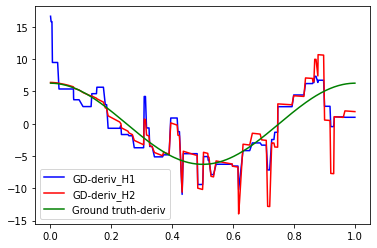

In [19]:
plt.plot(sorted_X_test, y_pred_deriv_h1[test_order], label='GD-deriv_H1', color='b')
plt.plot(sorted_X_test, y_pred_deriv_h2[test_order], label='GD-deriv_H2', color='r')
# plt.plot(sorted_X_test, y_pred_deriv_gfree[test_order], label='GD-gfree',color='black')
plt.plot(sorted_X_test, true_deriv, label='Ground truth-deriv', color='g')
plt.legend()
plt.show()

In [20]:
print("Test L2 loss for the H1 gradient descent: {:.3f}".format(np.linalg.norm(y_test - y_pred_test_h1)))
print("Test L2 loss for the H2 gradient descent: {:.3f}".format(np.linalg.norm(y_test - y_pred_test_h2)))
print("Test L2 loss for the gradient-free descent: {:.3f}".format(np.linalg.norm(y_test - y_pred_test_gfree)))
print("Test L2 loss for the KNN regressor: {:.3f}".format(np.linalg.norm(y_test - knn_pred_y_test)))
print("Test L2 loss for the KRR: {:.3f}".format(np.linalg.norm(y_test - krr_pred_y_test)))
print("Test L2 loss for the GP regressor: {:.3f}".format(np.linalg.norm(y_test - gpr_pred_y_test)))

Test L2 loss for the H1 gradient descent: 2.680
Test L2 loss for the H2 gradient descent: 2.703
Test L2 loss for the gradient-free descent: 2.606
Test L2 loss for the KNN regressor: 3.444
Test L2 loss for the KRR: 2.017
Test L2 loss for the GP regressor: 3.070


Comparison of the losses on the test sample

Plot of the training loss

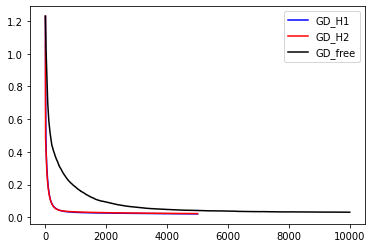

In [21]:
loss_train_h1 = np.mean((F_train_h1 - Y_train.reshape((1, -1)))**2, axis=1)
loss_train_h2 = np.mean((F_train_h2 - Y_train.reshape((1, -1)))**2, axis=1)
loss_train_gfree = np.mean((F_train_gfree - Y_train.reshape((1, -1)))**2, axis=1)

plt.figure()
plt.plot(loss_train_h1, label="GD_H1", color='blue')
plt.plot(loss_train_h2, label="GD_H2", color='red')
plt.plot(loss_train_gfree, label="GD_free", color='black')
plt.legend()
plt.show()

# Non-parametric regression in higher dimension

We consider a regression model $Y=h(X)+E$ where $(X,Y)$ are the observations, $E$ is a gaussian noise and $h$ is the function we want to learn. We assume that $h$ is a continuous function that belongs to the space
$$H = \{g, \ g(t) = \int_0^{t_1} \int_0^{t_d} g'(s) d s, \ g' \in L^2([0,1]^d)$$ and that the support of the distribution of $X$ is included in $[0,1]^d$. 

We set $L(h)$ as the squared loss associated to the model (i.e $L(h) = \mathbb{E}(Y-h(X))^2$ ).

We can thus compute the Malliavin Gradient of $L$ with respect to $h$ as: $$\nabla L (h) (.) = \mathbb{E}\Biggl[ 2(Y-h(X)) \Phi(.,X) \Biggr] \ .$$

Define the kernel functions for all $t \in [0,1]^d$ as $$\Phi_t(.) = \Pi_{k=1}^d (._k \wedge t_k).$$ 

Theoretically, we have now all the tools to perform a simple gradient descent to learn $h$. 
If we denote by $(X_i,Y_i)_{i=1,..,n}$ our training sample, then the gradient descent update takes the form: 
$$ h^{t+1}(.) = h^t(.) - 2 \alpha \frac{1}{n} \sum_{i}(Y_i-h^t(X_i)) \Phi_{X_i}(.) \ ,$$ 
where $\alpha$ is the stepsize. 

Again, the idea is to first compute the table $\{h^{t}(X_i)\}_{i \in [1,n], t \in [1,T]}$. Then, by a telescoping series argument, we have
$$ h^T(.) = h^0(.) - 2 \alpha \sum_{t=1,..,T} \frac{1}{n} \sum_{i} (Y_i - h^t(X_i)) \Phi_{X_i}(.) \ .$$

For general losses, referring to Malliavin Calculus, one can compute an unbiased estimate of the gradient using only the loss itself and a Brownian sheet $B$
$$ \hat{\nabla L} (h) (.) = \frac{1}{\gamma} L(h(X)+ \gamma B_X) B(.) \ ,$$
where $\gamma$ is a smoothing parameter.

Therefore, we can now perform the gradient-free SGD:
$$h^{t+1}(.) = h^t(.) -  \frac{\alpha}{\gamma} \frac{1}{n} \sum_{i} L(h^t(X_i)+ \gamma B^t_{X_i}) B^t(.) \ ,$$
which can be implemented exactly using the same argument as before.

## In a general setting

In general, the function we want to learn does not belong to $H$, but that should not be a problem as long as it satisfies some regularity assumptions. Say the function $h$ is $\mathcal{C}^2$ on a domain $[a,b]^d$. Consider then for some $\varepsilon >0$ the function $h_\varepsilon : [\varepsilon , 1]^d \mapsto \mathbb{R}$
$$ h_\varepsilon (x) = h( (b-a) \frac{x-\varepsilon}{1-\varepsilon} + a ).$$
Next, consider an extension $\tilde{h}$ of $h_\varepsilon$ to $[0,1]^d$ such that $\tilde{h}(...,0,...) = 0$ and $\tilde{h}$ is $\mathcal{C}^2$. It is easy to see that $\tilde{h}$ belongs to the space $H$. Moreover, let $\mathcal{M}$ denote the mapping $h \mapsto \tilde{h}$, then $\tilde{h}$ satisfies the regression problem
$$ Y = M^{-1}(\tilde{h})(X)+E .$$

Since $X$ belongs to $[a,b]^d$, we can write the regresison problem as $$Y = h_\varepsilon(\frac{\frac{X-a}{b-a}+\varepsilon}{1-\varepsilon}) + E$$

Therefore, after modifying the sample $X$, the gradient descent described above can learn the function $h_\varepsilon$ on $[\varepsilon,1]^d$.

## Changing the space $H$ in higher dimension

The analysis done in dimension $1$ becomes much more difficult here. Let $B$ denote the boundary on which one of the coordinates vanishes. By analogy, consider the space
$H_2 = \{f \in H^2(0,1), f(0)=0, \nabla f . n _B= 0 \},$
embedded with the scalar product 
$$ \langle f, g \rangle = \int_{[0,1]^2} \langle \nabla f , \nabla g \rangle + \int_{[0,1]^2} \Delta f \Delta g .$$
In this case, finding the Fréchet gradient $g$ of $h \mapsto h(t)$ requires solving 
$$ \Delta (\Delta-I)g = \delta_t ,$$
which is not a trivial problem. 

## Complex losses : spectral risks

Learning problems can usually be stated in terms of minimising the risk $\mathbb{E} L(w; Z)$, where $Z$ is a random observation, and $w$ characterizes some decision rule. We consider here a family of more complex risks (spectral risks), which we can write as
$$ R_\sigma(w) = \mathbb{E} L(w;Z) \sigma( F_w(L(w;Z)) ,$$
where $F_w$ is the CDF of the distribution of $L(w;Z)$ and $\sigma : [0,1] \mapsto \mathbb{R}_+$ is a non-negative, non-decreasing function that integrates to $1$.

In this case, gradient methods fail because while $F_w$ may be differentiable with respect to $w$, it is never known in practice. Even in an ideal setting where $F_w$ is the CDF of a Gaussian distribution with standard deviation $\| w \|_2$, its gradient is not easy to compute. 

If $w$ is a function of the space $H$, one can perform the gradient-free approach described above.